In [1]:
# Import libraries
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
from datetime import timedelta
from hurst import compute_Hc

In [2]:
# Function to calculate the Hurst exponent
def hurst_exponent(ts):
    
    H = compute_Hc(ts, kind='price')[0]
    return H

# Function to calculate the rolling Hurst exponent
def rolling_hurst(df, window=240):
    return df['Close'].rolling(window=window).apply(hurst_exponent, raw=False)

# Load the price data from the CSV file
df = pd.read_csv('ETH.csv')

# Set the datetime index

df = df.set_index('time')
df.index = pd.to_datetime(df.index)
df.rename(columns={"close":"Close"},inplace=True)


In [3]:
# Compute the rolling Hurst values with a lookback period of 240 bars
df['Hurst'] = rolling_hurst(df)

# Calculate the RSI with a window size of 14
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

# Initialize variables for backtesting
initial_capital = 10000
capital = initial_capital
position = 0  # 0 means no position, 1 means long, -1 means short
entry_price = 0
entry_time = None
trade_log = []
strategy_returns = []

# Parameters for slippage and transaction costs
slippage = 0.001  # 0.1% slippage

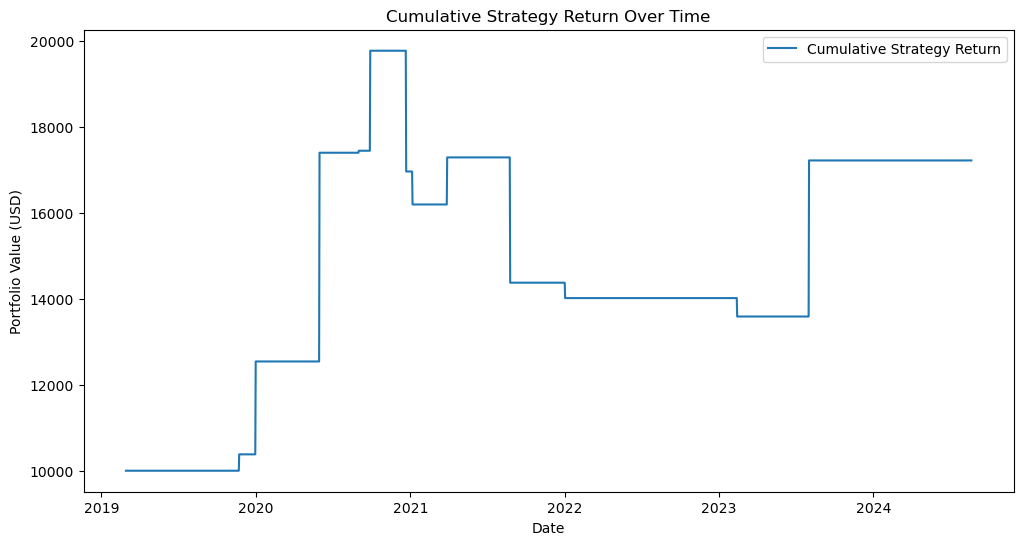

   Entry Time  Exit Time  Entry Price  Exit Price Position  Trade Return  \
0  2019-11-24 2019-12-29    139.82004   134.49436    Short      0.038090   
1  2020-02-05 2020-02-25    203.98378   246.42333     Long      0.208054   
2  2020-07-24 2020-08-21    279.42915   387.58203     Long      0.387049   
3  2020-11-21 2020-12-08    552.90235   554.38506     Long      0.002682   
4  2021-01-03 2021-01-21    979.25828  1109.84904     Long      0.133357   
5  2021-04-15 2021-04-19   2516.55404  2158.95888     Long     -0.142097   
6  2021-05-03 2021-05-17   3434.47104  3279.22749     Long     -0.045202   
7  2021-08-06 2021-08-26   2894.47158  3090.10680     Long      0.067589   
8  2022-01-21 2022-02-04   2565.58185  2997.98499    Short     -0.168540   
9  2022-06-13 2022-07-07   1208.61018  1238.72749    Short     -0.024919   
10 2023-08-17 2023-08-29   1679.80851  1731.14942    Short     -0.030564   
11 2024-02-14 2024-03-16   2777.58481  3519.56691     Long      0.267132   

         Ca

In [4]:
# Event-driven backtesting loop
for i in range(1, len(df)):
    current_hurst = df['Hurst'].iloc[i]
    current_rsi = df['RSI'].iloc[i]
    current_price = df['Close'].iloc[i]
    
    # Check for long entry signals
    if position == 0:
        if current_rsi > 75 and current_hurst > 0.65:
            entry_price = current_price * (1 + slippage)
            entry_time = df.index[i]
            position = 1  # Go long
        elif current_rsi < 25 and current_hurst < 0.35:
            entry_price = current_price * (1 + slippage)
            entry_time = df.index[i]
            position = 1  # Go long
            
    # Check for short entry signals
    if position == 0:
        if current_rsi > 75 and current_hurst < 0.35:
            entry_price = current_price * (1 - slippage)
            entry_time = df.index[i]
            position = -1  # Go short
        elif current_rsi < 25 and current_hurst > 0.65:
            entry_price = current_price * (1 - slippage)
            entry_time = df.index[i]
            position = -1  # Go short

    # Check for exit signal (hurst close to 0.5)
    if position != 0 and 45 <= current_rsi <= 55:
        exit_price = current_price * (1 - slippage) if position == 1 else current_price * (1 + slippage)
        exit_time = df.index[i]
        trade_return = (exit_price - entry_price) / entry_price if position == 1 else (entry_price - exit_price) / entry_price
        capital += capital * trade_return
        
        # Log the trade
        trade_log.append({
            'Entry Time': entry_time,
            'Exit Time': exit_time,
            'Entry Price': entry_price,
            'Exit Price': exit_price,
            'Position': 'Long' if position == 1 else 'Short',
            'Trade Return': trade_return,
            'Capital': capital
        })
        
        # Calculate strategy return
        strategy_returns.append(trade_return)
        
        # Close the position
        position = 0
    
    # If no trade occurs, record the current capital
    if position == 0:
        strategy_returns.append(0)

# Convert trade log to DataFrame
trade_log_df = pd.DataFrame(trade_log)

# Compute the cumulative strategy return

# Convert strategy returns to a Pandas Series
strategy_returns_series = pd.Series(strategy_returns, index=df.index[:len(strategy_returns)])

# Compute cumulative return as the product of returns
cumulative_return = (1 + strategy_returns_series).cumprod() * initial_capital

# Align cumulative strategy returns with the original dataframe index
cumulative_return = cumulative_return.reindex(df.index, method='ffill').fillna(method='ffill')



# Plot the cumulative strategy return
plt.figure(figsize=(12, 6))
plt.plot(df.index, cumulative_return, label='Cumulative Strategy Return')
plt.title('Cumulative Strategy Return Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.show()

# Save the trade log to a CSV file
trade_log_df.to_csv('trade_log_ETH.csv', index=False)

# Display the trade log
#print(trade_log_df)

# Calculate net profit after slippage
net_profit = capital - initial_capital
print(f"Net Profit after Slippage: {net_profit:.2f} USD")

In [17]:
# the strategy returns will be compared to buy and hold returns of ETH
bnh_returns = df.Close.pct_change()

# code to analyse the strategy returns against buy and hold returns of ETH
def backtest_analyser(strategy_returns: pd.Series, benchmark_returns: pd.Series):
    # Align the strategy and benchmark returns by merging the series on their datetime indices
    combined_df = pd.concat([strategy_returns, benchmark_returns], axis=1, join='inner')
    combined_df.columns = ['Strategy Returns', 'Benchmark Returns']
    
    # Nested functions for performance metrics
    def cumulative_return(returns):
        return (1 + returns).cumprod() - 1

    def annualised_return(returns):
        return np.prod(1 + returns) ** (252 / len(returns)) - 1

    def sharpe_ratio(returns, risk_free_rate=0):
        excess_returns = returns - risk_free_rate / 252
        return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

    def max_drawdown(returns):
        cum_returns = cumulative_return(returns)
        running_max = cum_returns.cummax()
        drawdown = cum_returns - running_max
        max_dd = drawdown.min()
        return max_dd, (drawdown == max_dd).idxmax()

    def max_drawdown_duration(returns):
        cum_returns = cumulative_return(returns)
        running_max = cum_returns.cummax()
        drawdown_duration = (cum_returns / running_max).groupby((cum_returns / running_max).eq(1).cumsum()).cumcount()
        max_duration = drawdown_duration.max()
        return max_duration

    def calmar_ratio(returns):
        max_dd, _ = max_drawdown(returns)
        return -annualised_return(returns) / max_dd

    def sortino_ratio(returns, risk_free_rate=0):
        downside_risk = returns[returns < 0].std() * np.sqrt(252)
        return (annualised_return(returns) - risk_free_rate) / downside_risk

    # Calculate metrics for strategy
    strategy_cum_return = cumulative_return(combined_df['Strategy Returns'])
    strategy_ann_return = annualised_return(combined_df['Strategy Returns'])
    strategy_sharpe = sharpe_ratio(combined_df['Strategy Returns'])
    strategy_max_dd, _ = max_drawdown(combined_df['Strategy Returns'])
    strategy_max_dd_percent = strategy_max_dd * 100
    strategy_max_dd_duration = max_drawdown_duration(combined_df['Strategy Returns'])
    strategy_calmar = calmar_ratio(combined_df['Strategy Returns'])
    strategy_sortino = sortino_ratio(combined_df['Strategy Returns'])

    # Calculate metrics for benchmark
    benchmark_cum_return = cumulative_return(combined_df['Benchmark Returns'])
    benchmark_ann_return = annualised_return(combined_df['Benchmark Returns'])
    benchmark_sharpe = sharpe_ratio(combined_df['Benchmark Returns'])
    benchmark_max_dd, _ = max_drawdown(combined_df['Benchmark Returns'])
    benchmark_max_dd_percent = benchmark_max_dd * 100
    benchmark_max_dd_duration = max_drawdown_duration(combined_df['Benchmark Returns'])
    benchmark_calmar = calmar_ratio(combined_df['Benchmark Returns'])
    benchmark_sortino = sortino_ratio(combined_df['Benchmark Returns'])

    # Display statistics in a vertical tabular box
    print(f"{'Metric':<25} {'Strategy Metrics':<20} {'Benchmark Metrics':<20}")
    print(f"{'-'*65}")
    print(f"{'Cumulative Return:':<25} {strategy_cum_return[-1]:.2%} {'':<10} {benchmark_cum_return[-1]:.2%}")
    print(f"{'Annualised Return:':<25} {strategy_ann_return:.2%} {'':<10} {benchmark_ann_return:.2%}")
    print(f"{'Sharpe Ratio:':<25} {strategy_sharpe:.2f} {'':<10} {benchmark_sharpe:.2f}")
    print(f"{'Max Drawdown:':<25} {strategy_max_dd_percent:.2f}% {'':<10} {benchmark_max_dd_percent:.2f}%")
    print(f"{'Max Drawdown Duration:':<25} {strategy_max_dd_duration} days {'':<10} {benchmark_max_dd_duration} days")
    print(f"{'Calmar Ratio:':<25} {strategy_calmar:.2f} {'':<10} {benchmark_calmar:.2f}")
    print(f"{'Sortino Ratio:':<25} {strategy_sortino:.2f} {'':<10} {benchmark_sortino:.2f}")

    # Visualization
    fig, axs = plt.subplots(3, 1, figsize=(10, 18))
    
    # Cumulative returns plot
    axs[0].plot(strategy_cum_return, label='Strategy Cumulative Return', color='blue')
    axs[0].plot(benchmark_cum_return, label='Benchmark Cumulative Return', color='orange')
    axs[0].set_title('Cumulative Returns')
    axs[0].set_ylabel('Cumulative Return')
    axs[0].legend()

    # Underwater plot (Max Drawdown)
    strategy_drawdowns = strategy_cum_return - strategy_cum_return.cummax()
    benchmark_drawdowns = benchmark_cum_return - benchmark_cum_return.cummax()
    axs[1].plot(strategy_drawdowns, label='Strategy Drawdown', color='red')
    axs[1].plot(benchmark_drawdowns, label='Benchmark Drawdown', color='purple')
    axs[1].set_title('Underwater Plot (Drawdowns)')
    axs[1].set_ylabel('Drawdown')
    axs[1].legend()

    # Rolling Sharpe Ratio plot
    rolling_strategy_sharpe = combined_df['Strategy Returns'].rolling(window=90).apply(sharpe_ratio, raw=False)
    rolling_benchmark_sharpe = combined_df['Benchmark Returns'].rolling(window=90).apply(sharpe_ratio, raw=False)
    axs[2].plot(rolling_strategy_sharpe, label='Rolling 90-Day Strategy Sharpe Ratio', color='green')
    axs[2].plot(rolling_benchmark_sharpe, label='Rolling 90-Day Benchmark Sharpe Ratio', color='brown')
    axs[2].set_title('Rolling Sharpe Ratio (90-Day Window)')
    axs[2].set_ylabel('Sharpe Ratio')
    axs[2].legend()

    plt.tight_layout()
    plt.show()



Metric                    Strategy Metrics     Benchmark Metrics   
-----------------------------------------------------------------
Cumulative Return:        72.16%            1541.36%
Annualised Return:        8.02%            48.77%
Sharpe Ratio:             0.45            0.92
Max Drawdown:             -61.81%            -2817.24%
Max Drawdown Duration:    1112 days            790 days
Calmar Ratio:             0.13            0.02
Sortino Ratio:            0.07            0.91


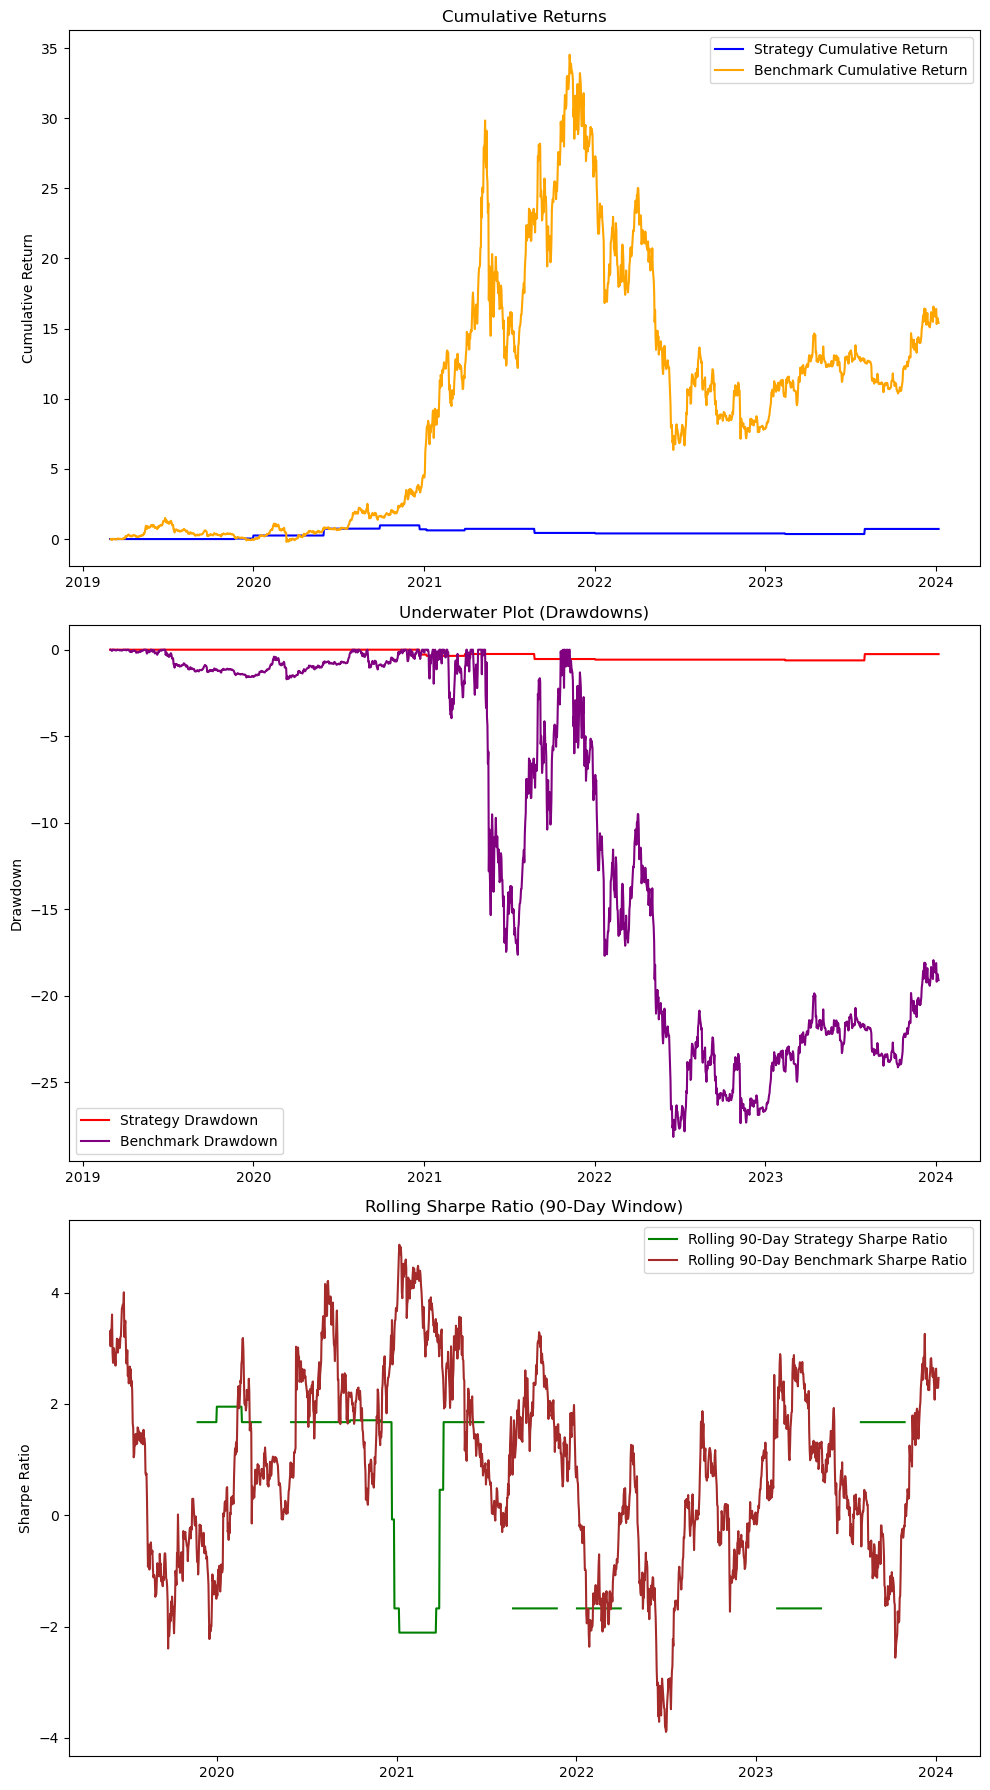

In [32]:
backtest_analyser(strategy_returns_series, bnh_returns)